**12. Projekt**
=================

## **1. Cel projektu**

#### Celem projektu jest przewidzenie cen mieszkań w zależności od różnych cech, tj.: **cena**, **powierzchnia**, **liczba pokoi**, **piętro**, **typ zabudowy**, **forma kuchni**, obecność **miejsca parkingowego** czy **przystanku komunikacji miejskiej**. Do osiągnięcia założeń zostaną wykorzystane, a następnie porównane różne modele uczenia maszynowego
* Regresja liniowa  
* SGD  
* Sieć neuronowa (Keras)

#### Dane _flats.tsv_ wykorzstane do uczenia pochodzą z zajęć numer 7.

## **2. Importowanie potrzebnych bibliotek**

In [236]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse
from tensorflow import keras

## **3. Wczytanie danych**

In [237]:
COLS = ['cena', 'Powierzchnia w m2', 'Liczba pokoi', 'Piętro' ,'Typ zabudowy', 'opis', 'Forma kuchni', 'Miejsce parkingowe']

flats = pd.read_csv('flats.tsv', header=0, sep='\t', skipinitialspace=True, usecols=COLS)
flats.head(10)

,cena,Powierzchnia w m2,Liczba pokoi,Miejsce parkingowe,Piętro,Typ zabudowy,Forma kuchni,opis
0,290386,46,2,brak miejsca parkingowego,parter,apartamentowiec,w aneksie,"Polecam mieszkanie 2 pokojowe o metrażu 46,68 ..."
1,450000,59,2,brak miejsca parkingowego,2,kamienica,w aneksie,Ekskluzywna oferta - tylko u nas! Projekt arch...
2,375000,79,3,brak miejsca parkingowego,5,blok,NaN,Polecam do kupna przestronne mieszkanie trzypo...
3,400000,63,3,w garażu,2,blok,odzielna,Dla rodziny albo pod wynajem. Świetna lokaliza...
4,389285,59,3,brak miejsca parkingowego,12,blok,w aneksie,NaN
5,539000,90,4,przynależne na ulicy,1,dom wielorodzinny/szeregowiec,w aneksie,Drodzy PaństwoZapraszam do zapoznania się z pr...
6,380931,66,3,w garażu,3,blok,NaN,"Rozkładowe, przestronne mieszkanie na trzecim ..."
7,225000,32,1,brak miejsca parkingowego,2,blok,NaN,Zapraszam do zapoznania się z ofertą sprzedaży...
8,235582,38,2,przynależne na ulicy,3,blok,w aneksie,NaN
9,664443,68,3,brak miejsca parkingowego,3,apartamentowiec,w aneksie,Zapraszamy do zapoznania się z inwestycją firm...


In [238]:
flats.describe()

,cena,Powierzchnia w m2,Liczba pokoi
count,4.938000e+03,4938.000000,4938.000000
mean,4.198150e+05,76.422033,2.844674
std,3.244901e+05,180.583310,1.247389
min,0.000000e+00,15.000000,1.000000
25%,2.824200e+05,45.000000,2.000000
50%,3.417040e+05,54.000000,3.000000
75%,4.500000e+05,72.000000,3.000000
max,1.000000e+07,11930.000000,8.000000


## **4. Preprocessing danych**

### 4.1. Obróbka odpowiednich cech

In [239]:
# zamiana "parter" na piętro 0
flats['Piętro'] = flats['Piętro'].apply(lambda x: 0 if x == 'parter' else x)

# usunięcie mieszkań, które są na poddaszu
flats['Piętro'] = flats['Piętro'].apply(pd.to_numeric, errors='coerce') 
flats = flats.dropna()

# Utowrzenie wartości bool'owskich (0 gdy nie ma jakiegokolwiek typu miejsca parkingowego)
flats['Miejsce parkingowe'] = flats['Miejsce parkingowe'].apply(lambda x: 1 if x in flats['Miejsce parkingowe'].unique()[1:] else 0)

# Utworzenie wartości kategorycznych
flats = pd.get_dummies(flats, columns=['Typ zabudowy', 'Forma kuchni'])

# Utworzenie wartości tekstowych
flats['Czy przystanek?'] = flats['opis'].apply(lambda x: 1 if 'przystanek' in x.lower() else 0)
del flats['opis']

### 4.2. Odcięcie odstających cen

In [240]:
# usunięcie mieszkań, których cena wynosi więcej niż 600 tys. zł
flats = flats.drop(flats[flats['cena'] > 6*10**5].index)

### 4.3 Normalizacja wartości numerycznych

In [241]:
scaler = MinMaxScaler()
cols_to_norm = [c for c in flats.columns if c in ['cena', 'Powierzchnia w m2', 'Liczba pokoi', 'Piętro']]
flats[cols_to_norm] = scaler.fit_transform(flats[cols_to_norm])

## **5. Wizualizacja cech na histogramach**

array([[<AxesSubplot:title={'center':'cena'}>,
        <AxesSubplot:title={'center':'Powierzchnia w m2'}>,
        <AxesSubplot:title={'center':'Liczba pokoi'}>,
        <AxesSubplot:title={'center':'Miejsce parkingowe'}>],
       [<AxesSubplot:title={'center':'Piętro'}>,
        <AxesSubplot:title={'center':'Typ zabudowy_apartamentowiec'}>,
        <AxesSubplot:title={'center':'Typ zabudowy_blok'}>,
        <AxesSubplot:title={'center':'Typ zabudowy_dom wielorodzinny/szeregowiec'}>],
       [<AxesSubplot:title={'center':'Typ zabudowy_kamienica'}>,
        <AxesSubplot:title={'center':'Typ zabudowy_plomba'}>,
        <AxesSubplot:title={'center':'Forma kuchni_odzielna'}>,
        <AxesSubplot:title={'center':'Forma kuchni_prześwit'}>],
       [<AxesSubplot:title={'center':'Forma kuchni_w aneksie'}>,
        <AxesSubplot:title={'center':'Czy przystanek?'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

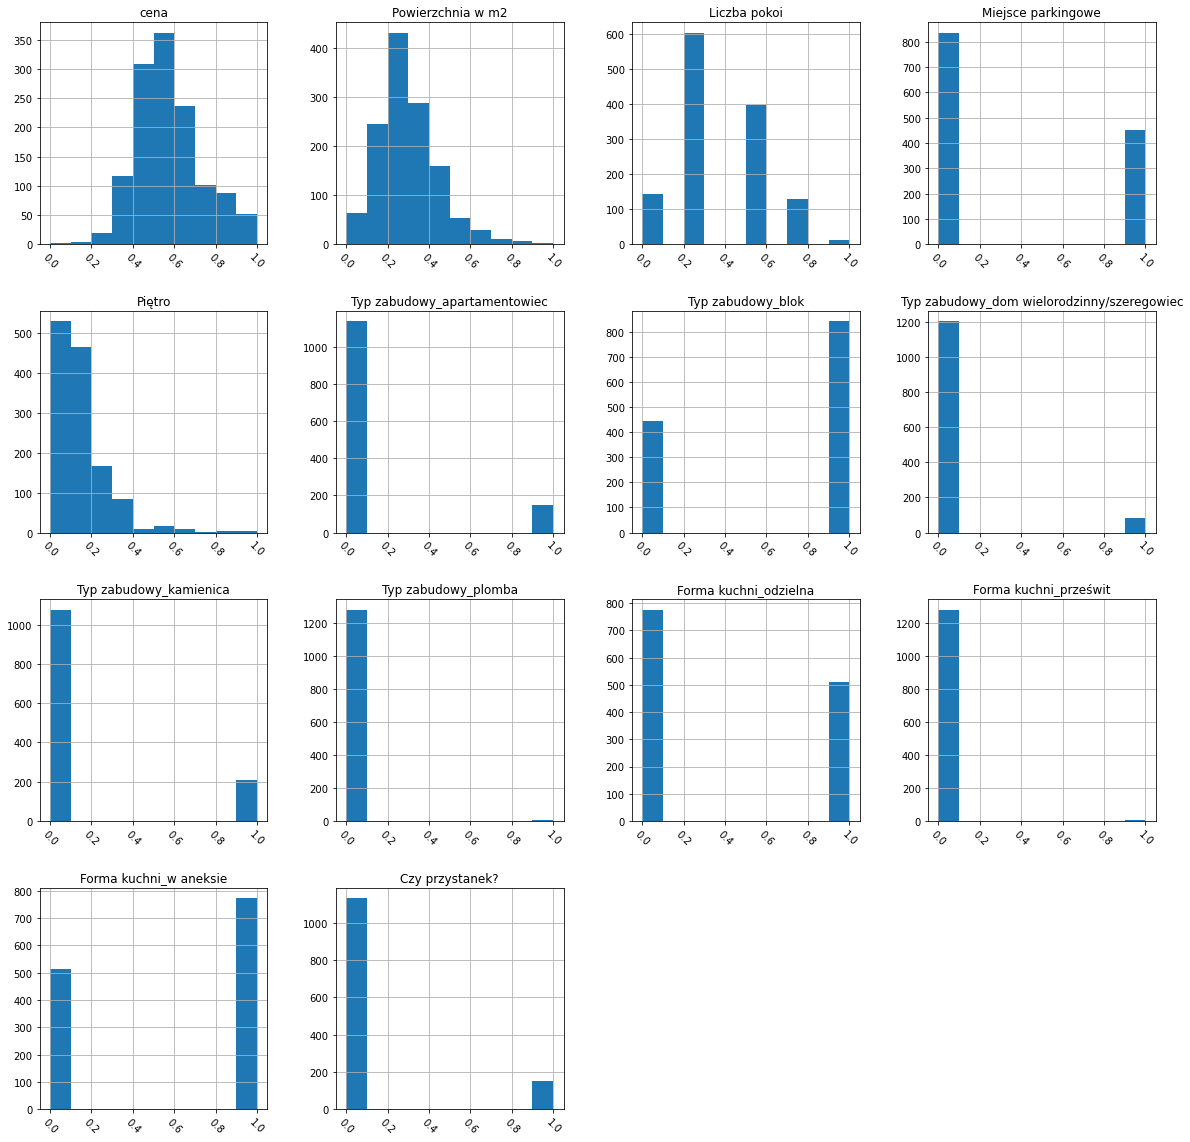

In [242]:
flats.hist(figsize=(20,20), xrot=-45)

## **6. Podział na zbiór testowy i treningowy**

In [243]:
SIZE = 0.2
SEED = 1300
X, y = flats[[c for c in flats.columns if c != 'cena']], flats['cena']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = SIZE, random_state = SEED)
print("X_train: ", len(X_train), '\n', "X_test: ", len(X_test))

X_train:  1028 
 X_test:  258


## **7. Trenowanie**

### 7.1. Regresja liniowa

In [244]:
reg = LinearRegression()
model = reg.fit(X_train, y_train)
score = model.score(X_test, y_test)
prediction = model.predict(X_test)
print("MSE:", rmse(y_test, prediction))
print("RMSE:", rmse(y_test, prediction, squared=False))
print("Score:", score)

MSE: 0.006900048705257726
RMSE: 0.08306653179986345
Score: 0.7170548639274577


### 7.2. Zrównoleglona optymalizacja stochastyczna (SGD)

In [311]:
sgd = SGDRegressor(max_iter=1000, alpha=.00000000001, tol=.00000001)
model = sgd.fit(X_train, y_train)
score = model.score(X_test, y_test)
prediction = model.predict(X_test)
print("MSE:", rmse(y_test, prediction))
print("RMSE:", rmse(y_test, prediction, squared=False))
print("Score:", score)

MSE: 0.00727747232386879
RMSE: 0.08530810233423781
Score: 0.7015781359090705


### 7.3. Sieć neuronowa (Keras)

In [317]:
EPOCHS = 50
BATCH_SIZE = 16 # 16

# Przygotowanie warstw
model = keras.Sequential([
        keras.layers.Dense(16,input_dim = X_train.shape[1],kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(16,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(8,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1,kernel_initializer='normal', activation='linear'),
    ])

# konfiguracja modelu
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# trenowanie
model.fit(X_train, y_train, epochs = EPOCHS, validation_split = 0.2, verbose = 1, batch_size = BATCH_SIZE)

# predykcja
prediction = model.predict(X_test)
mse_result = rmse(y_test, prediction)
rmse_result = rmse(y_test, prediction, squared=False)
print("MSE:", mse_result)
print("RMSE:", rmse_result)

Epoch 1/50
52/52 [==============================] - 0s 3ms/step - loss: 0.5575 - mean_absolute_error: 0.5575 - val_loss: 0.4177 - val_mean_absolute_error: 0.4177
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 0.2949 - mean_absolute_error: 0.2949 - val_loss: 0.1144 - val_mean_absolute_error: 0.1144
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1072 - mean_absolute_error: 0.1072 - val_loss: 0.1145 - val_mean_absolute_error: 0.1145
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1014 - mean_absolute_error: 0.1014 - val_loss: 0.1040 - val_mean_absolute_error: 0.1040
Epoch 5/50
52/52 [==============================] - 0s 2ms/step - loss: 0.0907 - mean_absolute_error: 0.0907 - val_loss: 0.0991 - val_mean_absolute_error: 0.0991
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 - val_loss: 0.0984 - val_mean_absolute_error: 0.0984
Epoch 7/50
52/52 [==========

## **8. Podsumowanie wyników**

|   | MSE | RMSE |
|---|---|---|
|Regresja liniowa|**0.0069**00048705257726|**0.0830**6653179986345|
|SGD|**0.0072**7747232386879|**0.0853**0810233423781|
|Sieć neuronowa (Keras)|**0.0063**37738546995088|**0.0796**0991487870772

#### Reasumując. Można zauważyć, że w tym przypadku najlepsze rezultaty z ewaluacji uzyskamy po zastosowaniu odpowiednio skonfigurowanej sieci neuronowej. 
#### Po zastosowaniu algorytmu SGD na rzecz zwykłej regresji liniowej, niestety nie udało się polepszyć wyników. Być może zastosowanie SGD dawałoby lepsze rezultaty (na pewno pod kątem złożoności) gdybyśmy działali na większym zbiorze danych.